In [1]:
import numpy as np
import seaborn as sns;
import pandas as pd
import itertools
import keras
from numba import cuda

from math import log2, ceil
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
import seaborn as sns

from pycpd import RigidRegistration
from pycpd import AffineRegistration
from pycpd import DeformableRegistration

In [2]:
from proglearn.sims import generate_gaussian_parity
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from proglearn.sims import generate_gaussian_parity

# Functions

In [3]:
#Function to rotate distribution
def rotate(X, theta=0, dim=[0,1]):
    #dimensions to rotate
    Z = X[:, dim]
    
    #rotation
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    Z = Z @ R
    
    #recombine
    X[:, dim] = Z
    
    return X

#Function to shear in the X direction
def shearX(X, s=0, dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    
    #shear
    R = np.array([[1, 0], [s, 1]])
    Z = Z @ R
    
    #recombine
    X[:, dim] = Z
    
    return X

#Function to shear in the Y direction
def shearY(X, s=0, dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    
    #shear
    R = np.array([[1, s], [0, 1]])
    Z = Z @ R
    
    #recombine
    X[:, dim] = Z
    
    return X

#Function to double shear in the X direction
def double_shearX(X, y, ss=(0,0) , dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    i,j = dim
    t,b = ss
    
    Z_top = Z[Z[:,j] >= 0]
    Z_bot = Z[Z[:,j] < 0]
    c_top = y[Z[:,j] >= 0]
    c_bot = y[Z[:,j] < 0]
    
    #shear
    R_top = np.array([[1, 0], [t, 1]])
    R_bot = np.array([[1, 0], [b, 1]])
    Z_top = Z_top @ R_top
    Z_bot = Z_bot @ R_bot
    
    #recombine
    Z = np.concatenate((Z_top, Z_bot))
    y = np.concatenate((c_top, c_bot))
    X[:, dim] = Z
    
    return X, y

In [4]:
def generate_gaussian_parity(n_samples, centers=None, class_label=None,
    cluster_std=0.25, angle_params=None, random_state=None):

    if random_state != None:
        np.random.seed(random_state)

    if centers == None:
        centers = np.array([(-0.5, 0.5), (0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)])

    if class_label == None:
        class_label = [0, 1, 1, 0]

    blob_num = len(class_label)

    # get the number of samples in each blob with equal probability
    samples_per_blob = np.random.multinomial(
        n_samples, 1 / blob_num * np.ones(blob_num)
    )

    X, y = make_blobs(
        n_samples=samples_per_blob,
        n_features=2,
        centers=centers,
        cluster_std=cluster_std,
    )

    for blob in range(blob_num):
        y[np.where(y == blob)] = class_label[blob]
        
    if angle_params != None:
        R = _generate_2d_rotation(angle_params)
        X = X @ R

    return X, y

def _generate_2d_rotation(theta=0):
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

    return R

# Visualizing Transformation

In [5]:
X1, y1 = generate_gaussian_parity(1000);
X2, y2 = generate_gaussian_parity(1000);
X3, y3 = generate_gaussian_parity(1000);
X4, y4 = generate_gaussian_parity(1000);

X2 = rotate(X2, theta=np.pi/6);
X3 = shearX(X3, s=1);
X4, y4 = double_shearX(X4, y4, ss=(2,0));

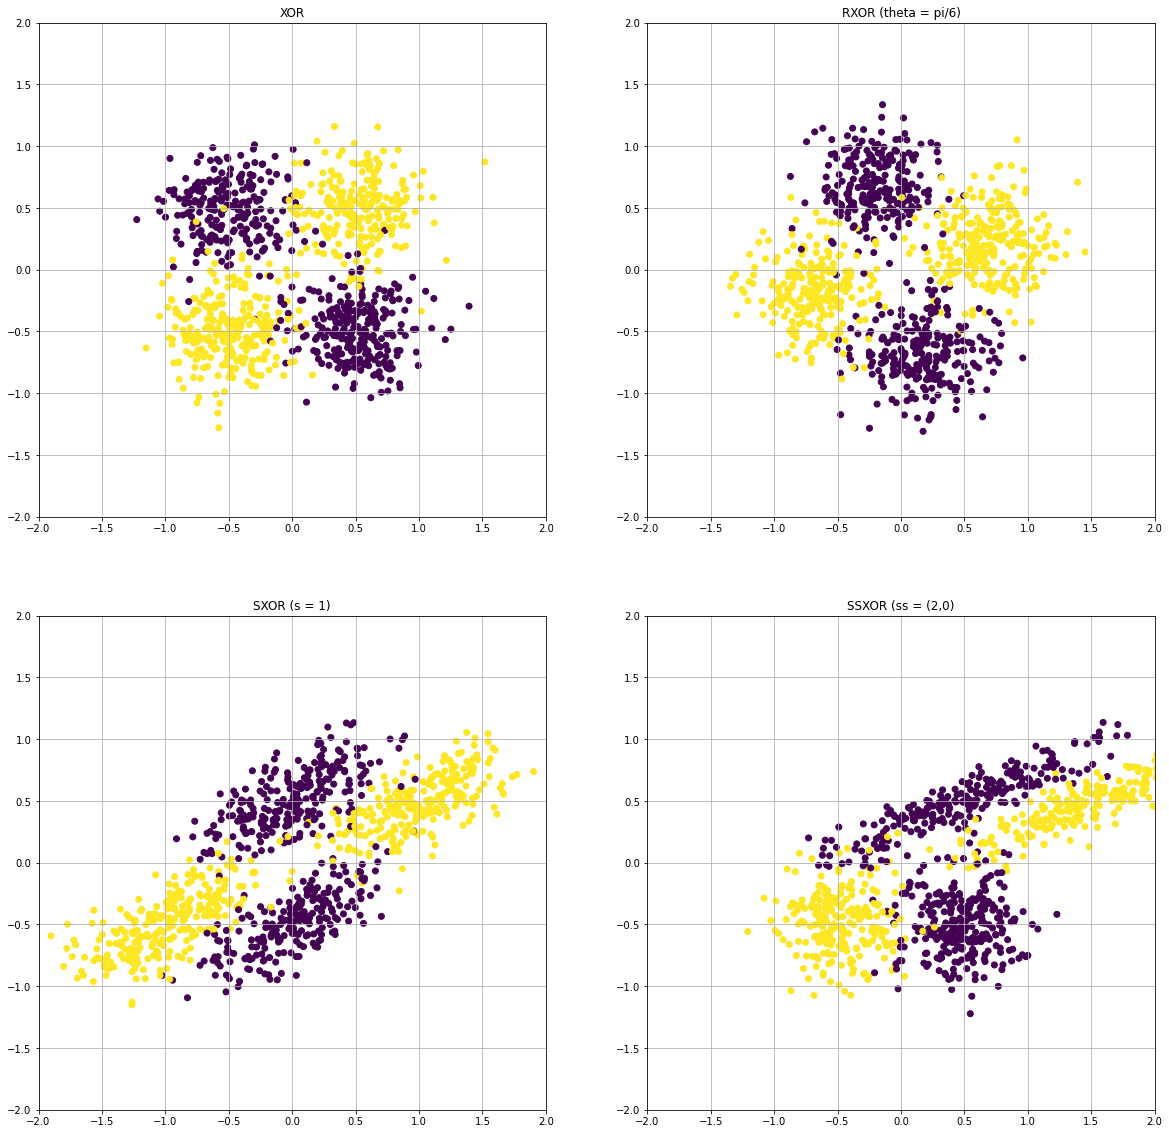

In [6]:
plt.figure(figsize=(20,20));

plt.subplot(221);
plt.scatter(X1[:,0], X1[:,1], c=y1);
plt.title("XOR");
plt.xlim([-2,2]); plt.ylim([-2,2]);
plt.grid();

plt.subplot(222);
plt.scatter(X2[:,0], X2[:,1], c=y2);
plt.title("RXOR (theta = pi/6)");
plt.xlim([-2,2]); plt.ylim([-2,2]);
plt.grid();

plt.subplot(223);
plt.scatter(X3[:,0], X3[:,1], c=y3);
plt.title("SXOR (s = 1)");
plt.xlim([-2,2]); plt.ylim([-2,2]);
plt.grid();

plt.subplot(224);
plt.scatter(X4[:,0], X4[:,1], c=y4);
plt.title("SSXOR (ss = (2,0)");
plt.xlim([-2,2]); plt.ylim([-2,2]);
plt.grid();

# Visualizing Decision Boundaries for Shear

In [7]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])

#Grid Setup
l = 3
h = 0.05 
xx, yy = np.meshgrid(np.arange(-l, l, h), np.arange(-l, l, h))
grid = np.c_[xx.ravel(), yy.ravel()]

In [8]:
#distribution generation
X = [];
y = [];

#S = [-100, -10, -5, -2, -1, -0.5, 0, 0.5, 1, 2, 5, 10, 100];
S = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500];

for i in S:
    D,c = generate_gaussian_parity(1000);
    D = shearX(D, s=i);
    
    X.append(D);
    y.append(c);

#Original XOR
U,v = generate_gaussian_parity(1000);

In [9]:
#Prarameters
n_trees=10
max_depth=None

c = [];
p = [];

for i in range(len(S)):
    #Model
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(
        default_transformer_class = default_transformer_class,
        default_transformer_kwargs = default_transformer_kwargs,
        default_voter_class = default_voter_class,
        default_voter_kwargs = default_voter_kwargs,
        default_decider_class = default_decider_class,
        default_decider_kwargs = default_decider_kwargs)

    #Training and Prediction
    progressive_learner.add_task(U, v, num_transformers=n_trees)
    progressive_learner.add_task(X[i], y[i], num_transformers=n_trees)
    
    z = progressive_learner.predict(grid, task_id=0)
    q = progressive_learner.task_id_to_decider[0].predict_proba(grid)[:,0]
    
    #Store values
    c.append(z)
    p.append(q)

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

C:\Users\William\anaconda3\envs\NDD\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\William\anaconda3\envs\NDD\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


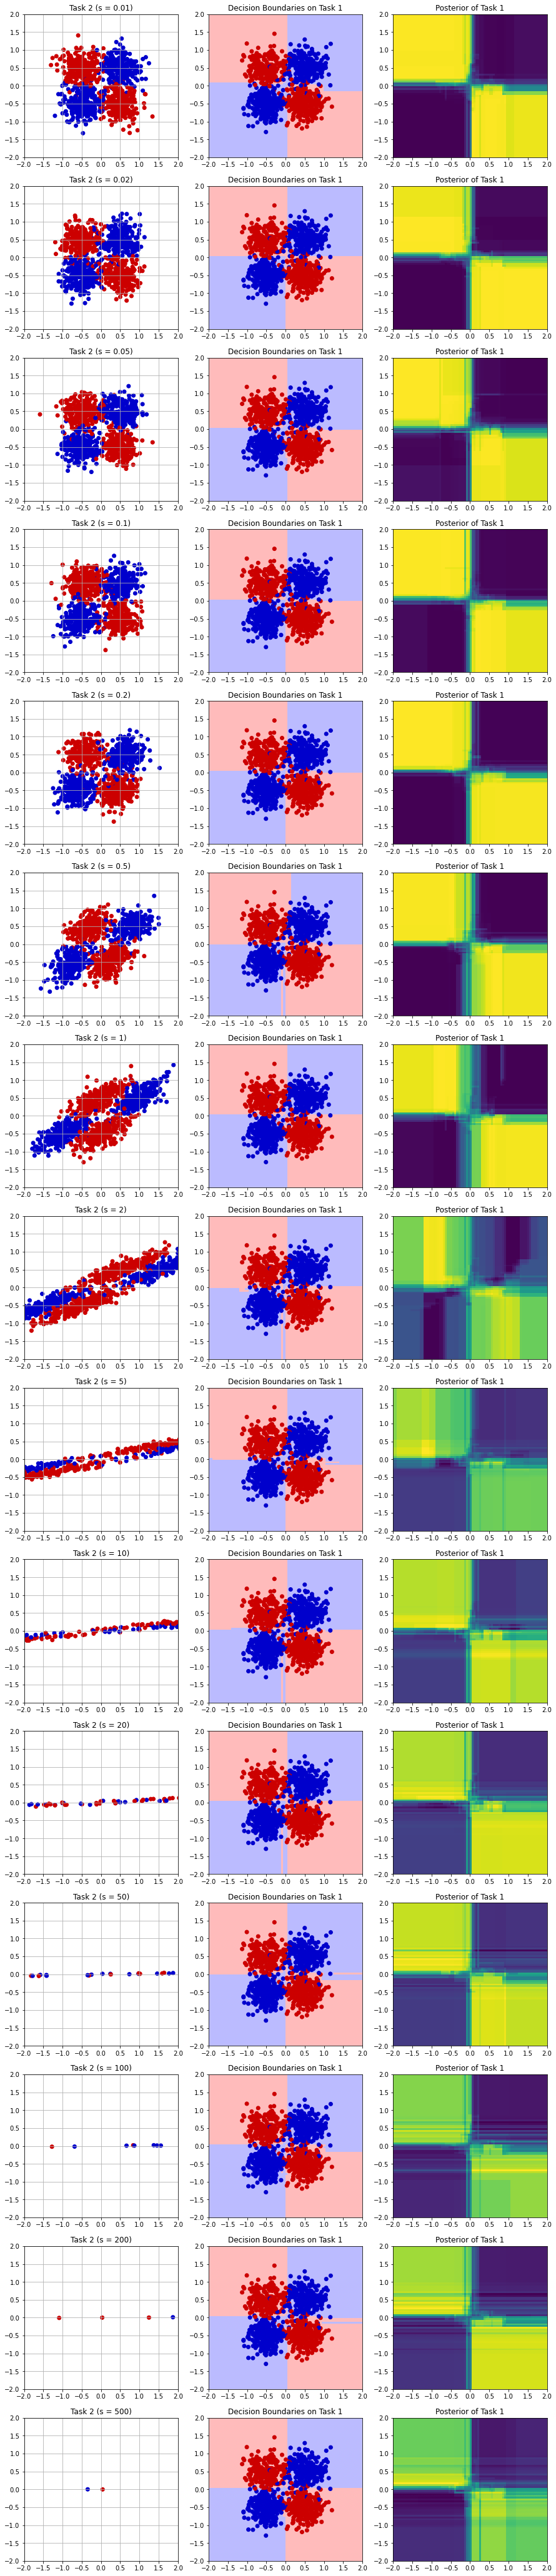

In [11]:
#Plot Decisions
l = 2;
w = 3;
n = len(S)
plt.figure(figsize=(w*5, n*5))

for i in range(n):
    #Decision Boundary
    zz = c[i];
    zz = zz.reshape(xx.shape);
    
    #Posteriors
    pp = p[i];
    pp = pp.reshape(xx.shape);
    
    #Task 2 Distribution
    x = X[i];
    
    plt.subplot(n,w, w*i+1);
    plt.scatter(x[:,0], x[:,1], c=y[i], cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.grid(); plt.title('Task 2 (s = {})'.format(S[i]));
    
    plt.subplot(n,w, w*i+2);
    plt.pcolormesh(xx, yy, zz, cmap=cmap_light);
    plt.scatter(U[:,0], U[:,1], c=v, cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.title('Decision Boundaries on Task 1');
    
    plt.subplot(n,w, w*i+3);
    plt.pcolormesh(xx, yy, pp);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.title('Posterior of Task 1');

# Visualizing Decision Boundaries for Double Shear 1
(Shearing only one side)

In [12]:
#distribution generation
X = [];
y = [];

S = [-100, -10, -5, -2, -1, -0.5, 0, 0.5, 1, 2, 5, 10, 100];

for i in S:
    D,c = generate_gaussian_parity(1000);
    D,c = double_shearX(D, c, ss=(i,0));
    
    X.append(D);
    y.append(c);

#Original XOR
U,v = generate_gaussian_parity(1000);

In [13]:
#Prarameters
n_trees=10
max_depth=None

c = [];
p = [];

for i in range(len(S)):
    #Model
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(
        default_transformer_class = default_transformer_class,
        default_transformer_kwargs = default_transformer_kwargs,
        default_voter_class = default_voter_class,
        default_voter_kwargs = default_voter_kwargs,
        default_decider_class = default_decider_class,
        default_decider_kwargs = default_decider_kwargs)

    #Training and Prediction
    progressive_learner.add_task(U, v, num_transformers=n_trees)
    progressive_learner.add_task(X[i], y[i], num_transformers=n_trees)
    
    z = progressive_learner.predict(grid, task_id=0)
    q = progressive_learner.task_id_to_decider[0].predict_proba(grid)[:,0]
    
    #Store values
    c.append(z)
    p.append(q)

In [14]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

C:\Users\William\anaconda3\envs\NDD\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\William\anaconda3\envs\NDD\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


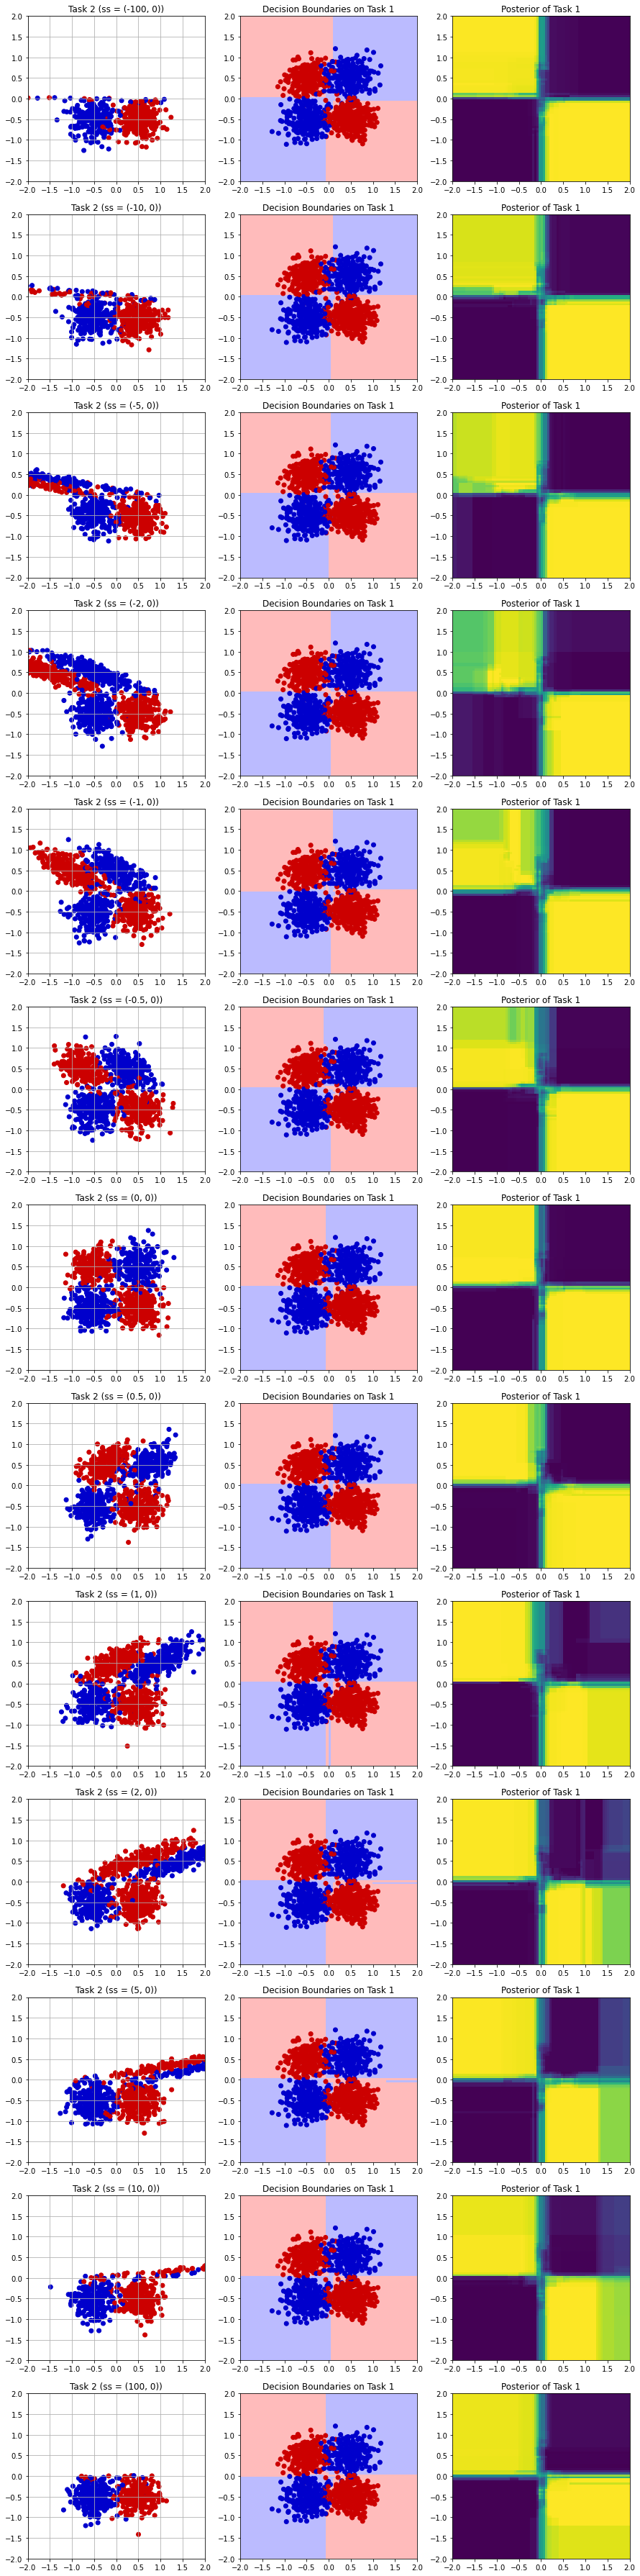

In [15]:
#Plot Decisions
l = 2;
w = 3;
n = len(S)
plt.figure(figsize=(w*5, n*5))

for i in range(n):
    #Decision Boundary
    zz = c[i];
    zz = zz.reshape(xx.shape);
    
    #Posteriors
    pp = p[i];
    pp = pp.reshape(xx.shape);
    
    #Task 2 Distribution
    x = X[i];
    
    plt.subplot(n,w, w*i+1);
    plt.scatter(x[:,0], x[:,1], c=y[i], cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.grid(); plt.title('Task 2 (ss = ({}, 0))'.format(S[i]));
    
    plt.subplot(n,w, w*i+2);
    plt.pcolormesh(xx, yy, zz, cmap=cmap_light);
    plt.scatter(U[:,0], U[:,1], c=v, cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.title('Decision Boundaries on Task 1');
    
    plt.subplot(n,w, w*i+3);
    plt.pcolormesh(xx, yy, pp);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.title('Posterior of Task 1');

# Visualizing Decision Boundaries for Double Shear 2
(Shearing both sides in opposite directions)

In [16]:
#distribution generation
X = [];
y = [];

S = [-100, -10, -5, -2, -1, -0.5, 0, 0.5, 1, 2, 5, 10, 100];

for i in S:
    D,c = generate_gaussian_parity(1000);
    D,c = double_shearX(D, c, ss=(i,-i));
    
    X.append(D);
    y.append(c);

#Original XOR
U,v = generate_gaussian_parity(1000);

In [17]:
#Prarameters
n_trees=10
max_depth=None

c = [];
p = [];

for i in range(len(S)):
    #Model
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(
        default_transformer_class = default_transformer_class,
        default_transformer_kwargs = default_transformer_kwargs,
        default_voter_class = default_voter_class,
        default_voter_kwargs = default_voter_kwargs,
        default_decider_class = default_decider_class,
        default_decider_kwargs = default_decider_kwargs)

    #Training and Prediction
    progressive_learner.add_task(U, v, num_transformers=n_trees)
    progressive_learner.add_task(X[i], y[i], num_transformers=n_trees)
    
    z = progressive_learner.predict(grid, task_id=0)
    q = progressive_learner.task_id_to_decider[0].predict_proba(grid)[:,0]
    
    #Store values
    c.append(z)
    p.append(q)

In [18]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

C:\Users\William\anaconda3\envs\NDD\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\William\anaconda3\envs\NDD\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


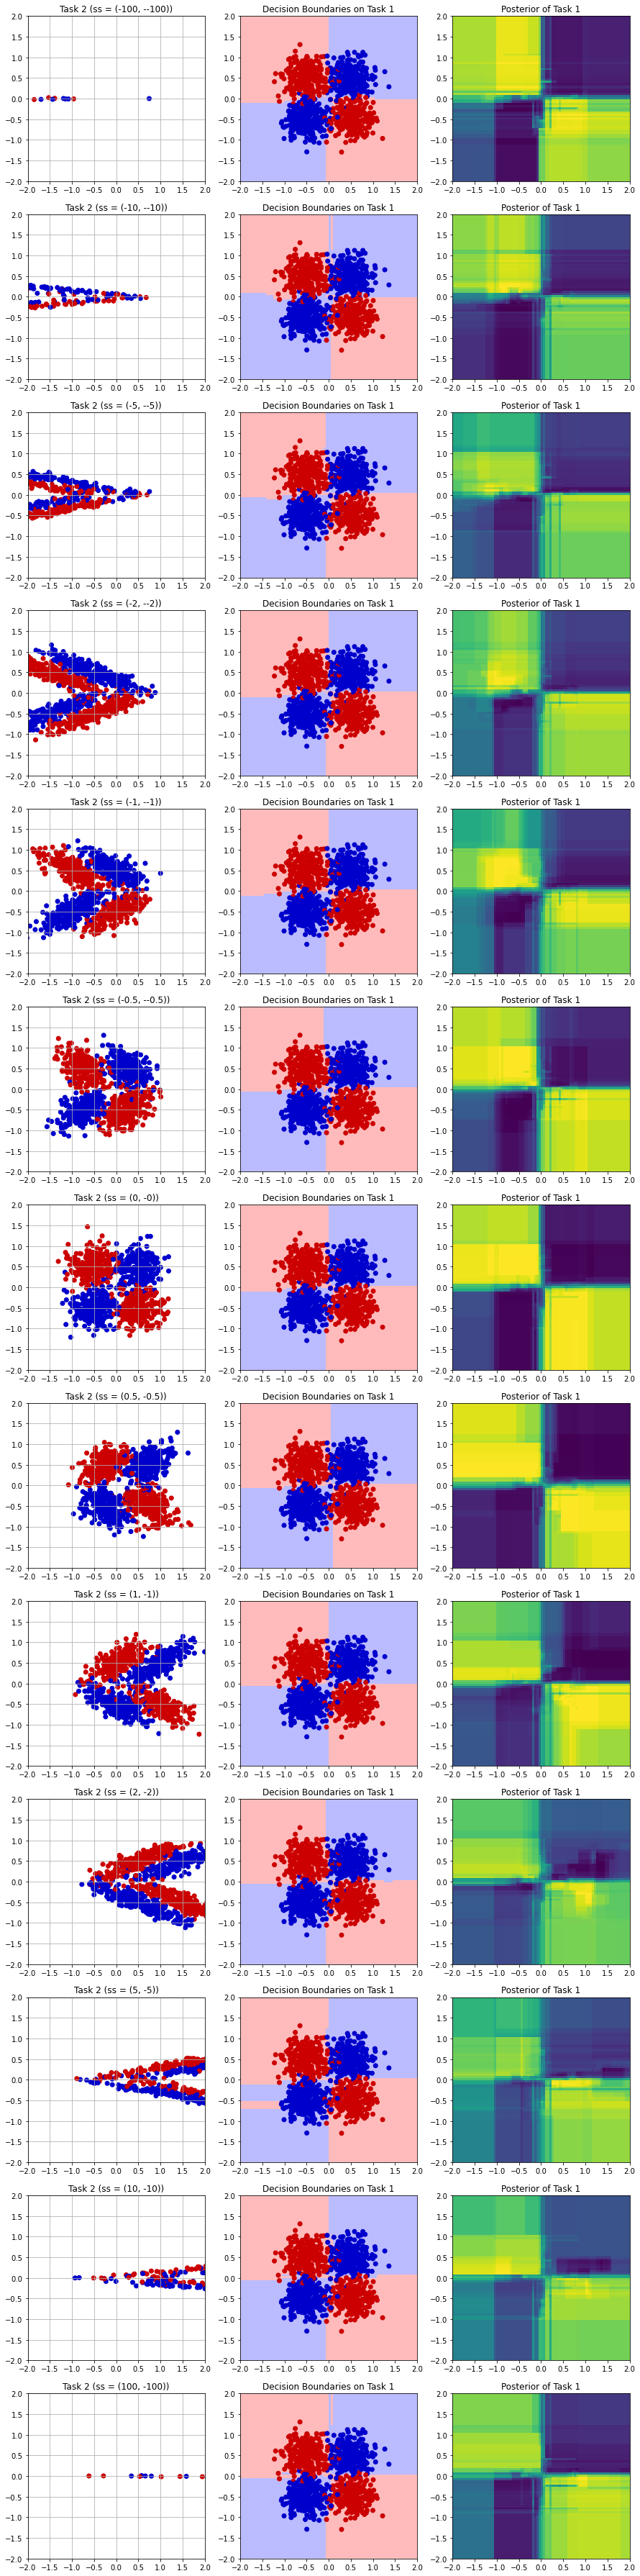

In [19]:
#Plot Decisions
l = 2;
w = 3;
n = len(S)
plt.figure(figsize=(w*5, n*5))

for i in range(n):
    #Decision Boundary
    zz = c[i];
    zz = zz.reshape(xx.shape);
    
    #Posteriors
    pp = p[i];
    pp = pp.reshape(xx.shape);
    
    #Task 2 Distribution
    x = X[i];
    
    plt.subplot(n,w, w*i+1);
    plt.scatter(x[:,0], x[:,1], c=y[i], cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.grid(); plt.title('Task 2 (ss = ({}, -{}))'.format(S[i], S[i]));
    
    plt.subplot(n,w, w*i+2);
    plt.pcolormesh(xx, yy, zz, cmap=cmap_light);
    plt.scatter(U[:,0], U[:,1], c=v, cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.title('Decision Boundaries on Task 1');
    
    plt.subplot(n,w, w*i+3);
    plt.pcolormesh(xx, yy, pp);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.title('Posterior of Task 1');

# Shear Experiment

In [20]:
def nearest_neighbor(src, dst, y_src, y_dst, class_aware=True):
    assert src.shape == dst.shape

    distances = np.zeros(y_src.shape)
    indices = np.zeros(y_src.shape, dtype=int)

    if class_aware:
        class1_src = np.where(y_src == 1)[0]
        class0_src = np.where(y_src == 0)[0]
        class1_dst = np.where(y_dst == 1)[0]
        class0_dst = np.where(y_dst == 0)[0]

        neigh_1 = NearestNeighbors(n_neighbors=1)
        neigh_1.fit(dst[class1_dst])
        distances_1, indices_1 = neigh_1.kneighbors(
            src[class1_src], return_distance=True
        )

        neigh_2 = NearestNeighbors(n_neighbors=1)
        neigh_2.fit(dst[class0_dst])
        distances_2, indices_2 = neigh_2.kneighbors(
            src[class0_src], return_distance=True
        )

        closest_class1 = class1_src[indices_1]
        closest_class0 = class0_src[indices_2]

        count = 0
        for i in class1_src:
            distances[i] = distances_1[count]
            indices[i] = closest_class1[count]
            count = count + 1

        count = 0
        for i in class0_src:
            distances[i] = distances_2[count]
            indices[i] = closest_class0[count]
            count = count + 1

    else:
        neigh = NearestNeighbors(n_neighbors=1)
        neigh.fit(dst)
        distances, indices = neigh.kneighbors(src, return_distance=True)

    return distances.ravel(), indices.ravel()


def best_fit_transform(A, B):
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
        Vt[m - 1, :] *= -1
        R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R, centroid_A.T)

    # homogeneous transformation
    T = np.identity(m + 1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def icp(A, B, y_src, y_dst, init_pose=None, max_iterations=500, tolerance=1e-26):
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m + 1, A.shape[0]))
    dst = np.ones((m + 1, B.shape[0]))
    src[:m, :] = np.copy(A.T)
    dst[:m, :] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    imbalance = []

    class1_src = np.where(y_src == 1)[0]
    class0_src = np.where(y_src == 0)[0]
    class1_dst = np.where(y_dst == 1)[0]
    class0_dst = np.where(y_dst == 0)[0]

    imbalance.append(len(class1_src))
    imbalance.append(len(class0_src))
    imbalance.append(len(class1_dst))
    imbalance.append(len(class0_dst))

    mi = min(imbalance)

    X_1 = src[:, class1_src[0:mi]]
    X_2 = src[:, class0_src[0:mi]]

    src_subsample = np.concatenate((X_1, X_2), 1)
    y_src_sub = np.concatenate((np.ones(mi), np.zeros(mi)))

    X_1 = dst[:, class1_dst[0:mi]]
    X_2 = dst[:, class0_dst[0:mi]]
    dst_subsample = np.concatenate((X_1, X_2), 1)
    y_dst_sub = np.concatenate((np.ones(mi), np.zeros(mi)))

    for i in range(max_iterations):

        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(
            src_subsample[:m, :].T, dst_subsample[:m, :].T, y_src_sub, y_dst_sub
        )
        # distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T, y_src, y_dst)

        # compute the transformation between the current source and nearest destination points
        T, _, _ = best_fit_transform(
            src_subsample[:m, :].T, dst_subsample[:m, indices].T
        )
        # T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src_subsample = np.dot(T, src_subsample)
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    # T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, src, i


def cpd_reg(template, target, max_iter=50):    
    registration = AffineRegistration(X=target, Y=template, max_iterations=max_iter)
    deformed_template = registration.register(template)
    
    return deformed_template[0]

In [21]:
def experiment(
    n_task1,
    n_task2,
    n_test=1000, 
    task1_angle=0,
    task2_shear=1, 
    n_trees=10,
    max_depth=None,
    random_state=None,
    register_cpd=False,
    register_otp=False,
    register_icp=False,
):

    if n_task1 == 0 and n_task2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6, dtype=float)

    #classifier setup
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes": np.arange(2)}
    progressive_learner = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )
    uf = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )
    naive_uf = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )

    #source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)

    #target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task1_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task1_angle)
    
    #transform task 2
    X_task2 = shearX(X_task2, s=task2_shear)
    test_task2 = shearX(test_task2, s=task2_shear)
 
    if register_cpd:
        X_task2 = cpd_reg(X_task2.copy(), X_task1.copy())
    
    if register_icp:
        T, X_3, i = icp(X_task2.copy(), X_task1.copy(), y_task2.copy(), y_task1.copy())
        X_task2 = X_3.T[:, 0:2]

    #train and predict
    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
    progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

    uf.add_task(X_task1, y_task1, num_transformers=2 * n_trees)
    uf.add_task(X_task2, y_task2, num_transformers=2 * n_trees)

    uf_task1 = uf.predict(test_task1, transformer_ids=[0], task_id=0)
    l2f_task1 = progressive_learner.predict(test_task1, task_id=0)

    errors[0] = 1 - np.mean(uf_task1 == test_label_task1)
    errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)

    return errors

In [22]:
def bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_cpd=False, register_otp=False, register_icp=False):
    mean_te = np.zeros(len(shear_sweep), dtype=float)
    for ii, s in enumerate(shear_sweep):
        error = np.array(
            Parallel(n_jobs=-1, verbose=1)(
                delayed(experiment)(
                    task1_sample,
                    task2_sample,
                    task2_shear=2,
                    max_depth=ceil(log2(task1_sample)),
                    register_cpd=register_cpd,
                    register_otp=register_otp,
                    register_icp=register_icp
                )
                for _ in range(mc_rep)
            )
        )

        mean_te[ii] = np.mean(error[:, 0]) / np.mean(error[:, 1])

    return mean_te

## Experiment

In [23]:
#main hyperparameters
shear_sweep = [x * 10**e for e in range(-2, 3) for x in [1, 2, 5]];
task1_sample = 100
task2_sample = 100
mc_rep = 250

In [24]:
shear_sweep

[0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500]

In [25]:
mean_te1 = bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | 

In [26]:
mean_te2 = bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | 

In [27]:
mean_te3 = bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | 

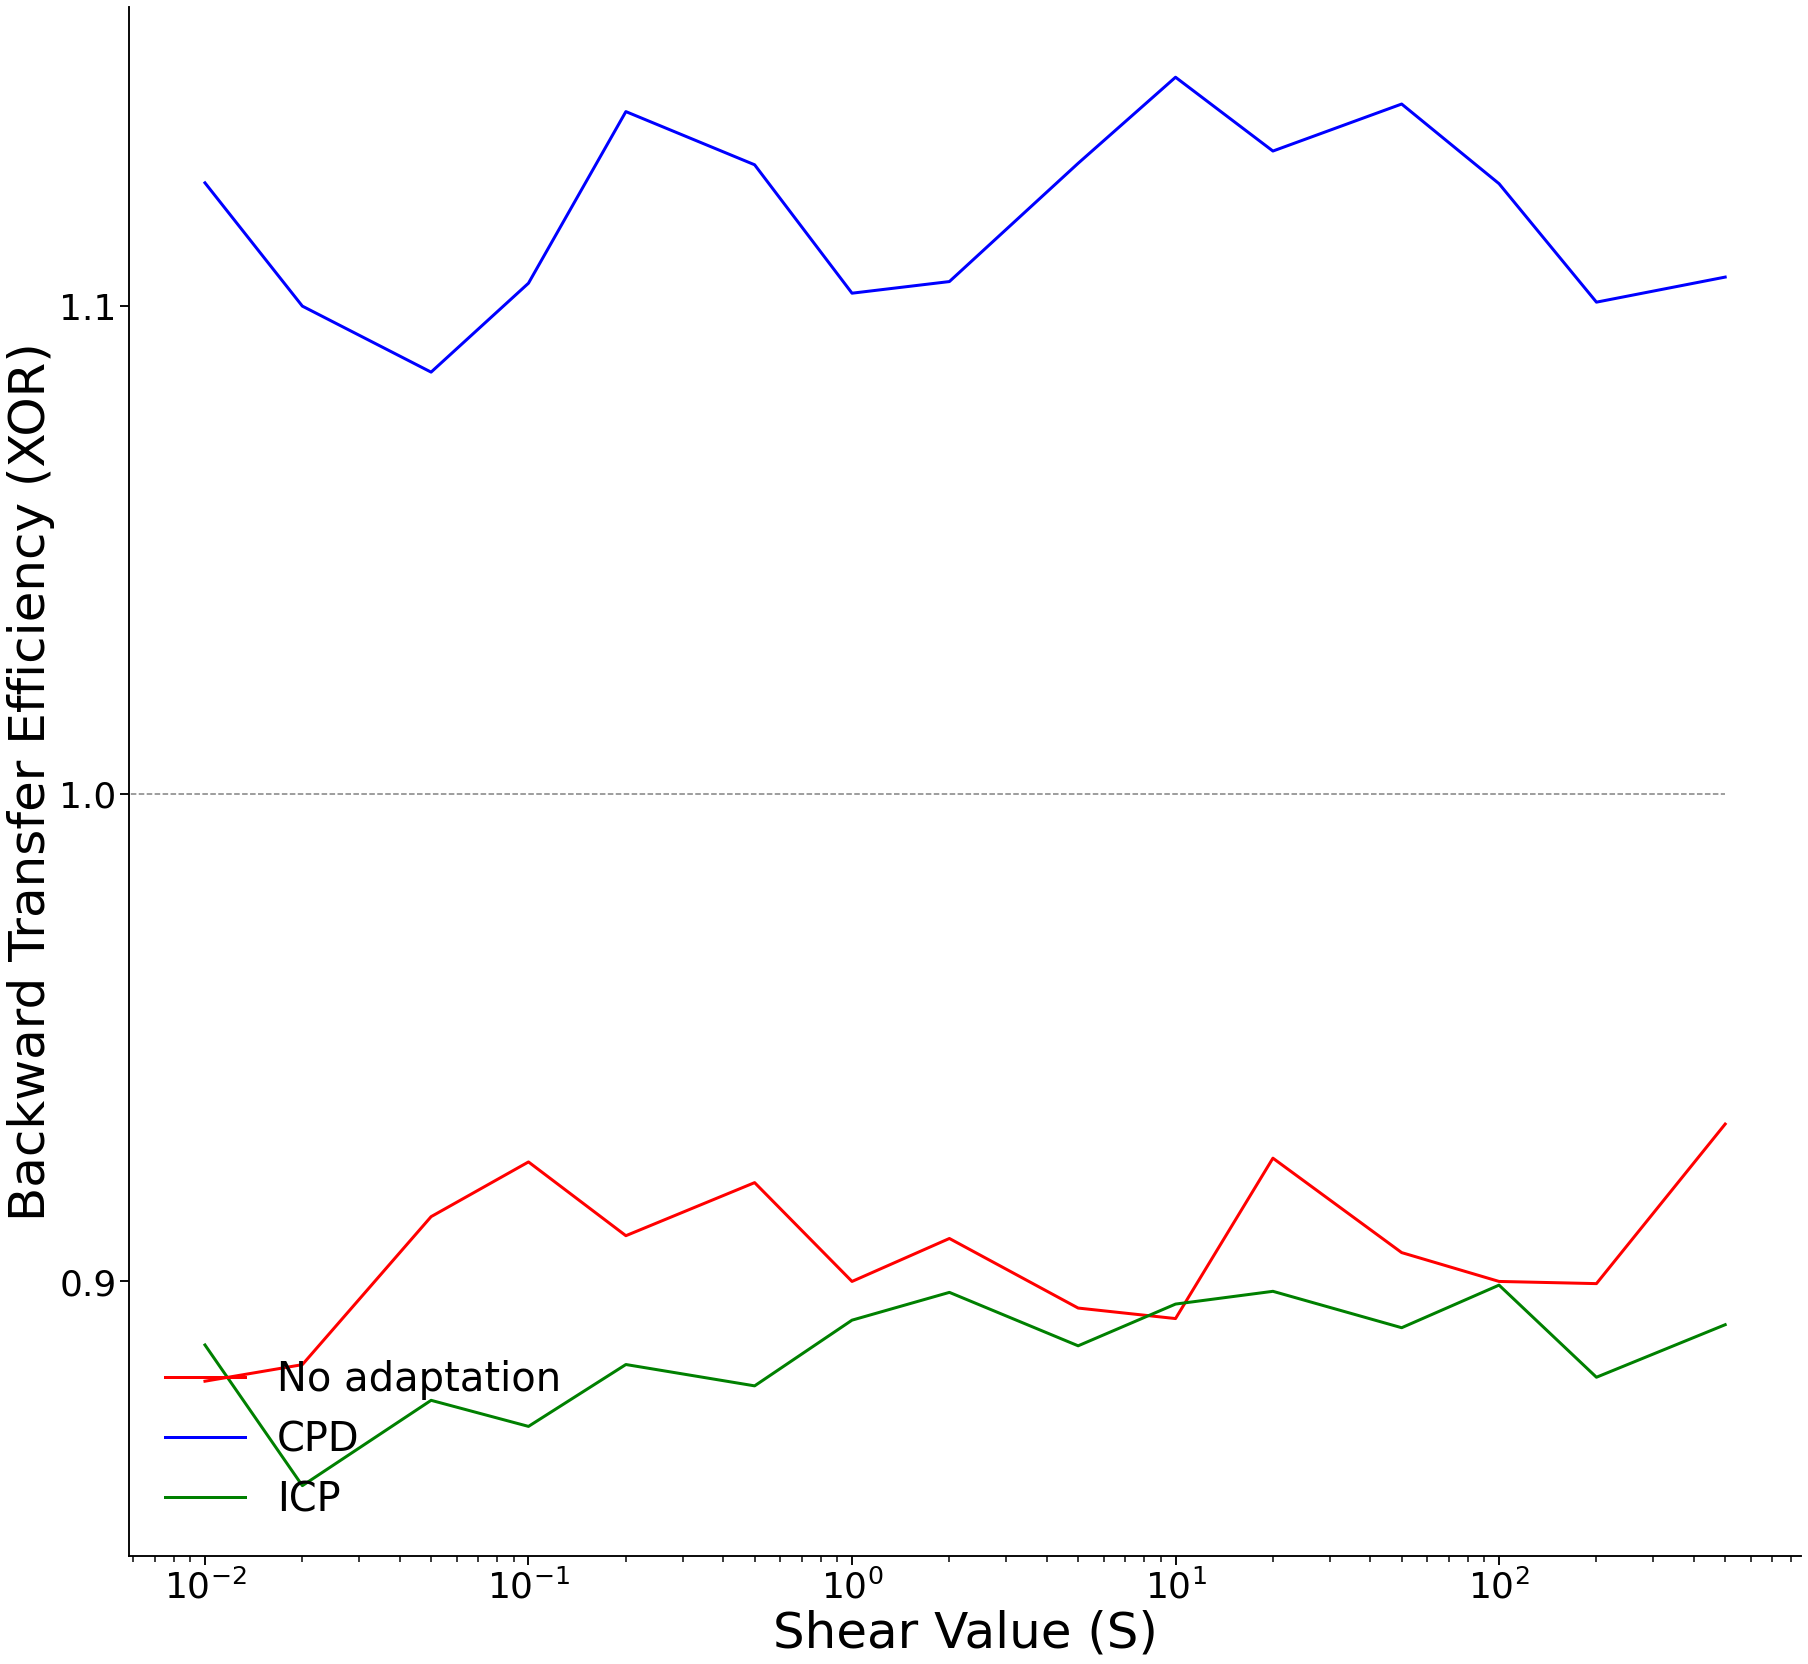

In [29]:
fontsize=50
labelsize = 36
    
sns.set_context("talk")
fig = plt.figure(constrained_layout=True, figsize=(25, 23))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
task = ["No adaptation", "CPD", "ICP"]
ax.plot(shear_sweep, mean_te1, c="r", linewidth=3, label=task[0])
ax.plot(shear_sweep, mean_te2, c="b", linewidth=3, label=task[1])
ax.plot(shear_sweep, mean_te3, c="g", linewidth=3, label=task[2])
ax.tick_params(labelsize=labelsize)
ax.set_xlabel("Shear Value (S)", fontsize=fontsize)
ax.set_ylabel("Backward Transfer Efficiency (XOR)", fontsize=fontsize)
ax.set_yticks([0.9, 1, 1.1, 1.2, 1.3])
ax.set_xscale('log')
ax.hlines(1, 0, 500, colors="grey", linestyles="dashed", linewidth=1.5)
ax.legend(loc="lower left", fontsize=40, frameon=False)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)